In [1]:
from nufeb_tools import utils,plot,spatial
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import os.path
import cv2

In [2]:
a = utils.get_data(directory=r'D:\runs\Run_50_50_100_1_2021-08-04_462847')

Assigning ancestry: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]


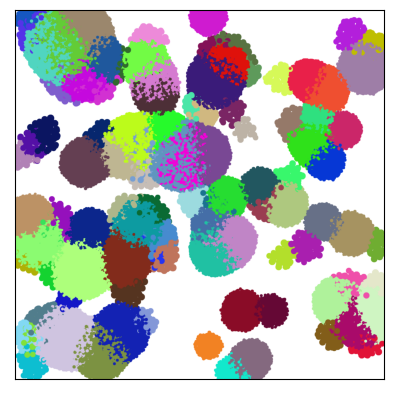

In [8]:
plot.colony(a,time=30000)
plt.show()

In [3]:
fname = 'positions.pkl'
if not os.path.isfile(fname):
    a = utils.get_data(directory=r'D:\runs\Run_50_50_100_1_2021-08-04_462847')
    a.positions
    a.positions.to_pickle('positions.pkl')
else:
    a = pd.read_pickle(fname)

In [4]:
df = a.copy()
df['mother_cell'] = -1
df.loc[df.Timestep==0,'mother_cell'] = df.loc[df.Timestep==0,'ID']
ancestry_df = df.loc[df.Timestep==0,['ID','mother_cell']]
type_=1
for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
    for type_ in df.type.unique():
        temp = df.loc[(df.type==type_) & (df.Timestep==time),['ID','x','y','z']]
        ancestors = temp.join(ancestry_df.set_index(['ID']),on='ID',how='inner', lsuffix='_left', rsuffix='_right')
        arr = ancestors[['x','y','z']].to_numpy()
        tree= KDTree(arr)
        motherless = pd.merge(temp,ancestors,on='ID',how='left', indicator=True).query('_merge == "left_only"').drop('_merge', 1).drop('x_y',1).iloc[:,:4]

        if not motherless.empty:
            d, i = tree.query(motherless[['x_x','y_x','z_x']].to_numpy(), k=1)
            motherless.loc[:,'mother_cell'] = ancestors.iloc[i,4].to_numpy()
            ancestry_df = pd.concat([ancestry_df,motherless.loc[:,['ID','mother_cell']]],ignore_index=True)
ancestry_df
df



Assigning ancestry: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]


,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell
0,0,66,2,6.600000e-07,0.000018,0.000005,0.000002,276.979899,0.000000,66
1,0,90,2,6.050000e-07,0.000013,0.000010,0.000002,213.345049,0.000000,90
2,0,75,2,6.200000e-07,0.000012,0.000010,0.000003,229.610378,0.000000,75
3,0,70,2,5.450000e-07,0.000035,0.000014,0.000003,155.957388,0.000000,70
4,0,3,1,9.350000e-07,0.000022,0.000020,0.000003,1266.849913,0.000000,3
...,...,...,...,...,...,...,...,...,...,...
8442311,35000,84352,2,4.483745e-07,0.000058,0.000100,0.000010,86.843888,97.222222,-1
8442312,35000,80072,2,4.627105e-07,0.000060,0.000100,0.000010,95.443109,97.222222,-1
8442313,35000,53661,2,4.343363e-07,0.000062,0.000100,0.000010,78.939594,97.222222,-1
8442314,35000,49522,2,4.534698e-07,0.000063,0.000100,0.000010,89.838305,97.222222,-1


In [33]:
df = a.copy()
#df['mother_cell'] = np.nan
df.loc[df.Timestep==0,'mother_cell'] = df.loc[df.Timestep==0,'ID']
#df.drop('mother_cell')
df = df.join(ancestry_df.set_index(['ID']),on='ID',how='right', lsuffix='_left', rsuffix='').drop('mother_cell_left',1)

df['total_biomass'] = df.groupby(['mother_cell','Timestep']).cumsum()['biomass']
df

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,total_biomass
0,0,66,2,6.600000e-07,0.000018,0.000005,0.000002,276.979899,0.000000,66,276.979899
100,100,66,2,5.148705e-07,0.000019,0.000005,0.000002,131.495403,0.277778,66,131.495403
235,200,66,2,5.150063e-07,0.000019,0.000005,0.000002,131.599422,0.555556,66,131.599422
382,300,66,2,5.152631e-07,0.000019,0.000005,0.000002,131.796429,0.833333,66,131.796429
529,400,66,2,5.156393e-07,0.000019,0.000005,0.000002,132.085303,1.111111,66,132.085303
...,...,...,...,...,...,...,...,...,...,...,...
8426920,35000,119858,1,8.026924e-07,0.000094,0.000068,0.000005,801.563226,97.222222,35,110576.507731
8429822,35000,119859,1,8.272959e-07,0.000065,0.000056,0.000008,877.552144,97.222222,46,90388.702803
8430125,35000,119860,1,7.404039e-07,0.000092,0.000069,0.000008,629.066421,97.222222,35,111205.574152
8431678,35000,119861,1,7.441318e-07,0.000094,0.000071,0.000009,638.616227,97.222222,15,44627.964965


In [ ]:
""" for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
    for type_ in df.type.unique():




            ancestry_df = pd.concat([ancestry_df,motherless.loc[:,['ID','mother_cell']]],ignore_index=True) """

In [18]:
def plot_colony(df,timepoint,ax=None,dims=[1e-4,1e-4,1e-5]):
    colors = tuple(np.random.randint(0,256, 3).astype('int'))
    ax = ax or plt.gca()


    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    tp = df[df.Timestep == timepoint]
    circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                color = (int(colors[cell][0]),int(colors[cell][1]),int(colors[cell][2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]


    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)


In [8]:
def get_mothers(dataframe):
    """
    Assign mother cells based on initial cells in the simulation.

    Returns:
        pandas.DataFrame:
            Dataframe containing Timestep, ID, type, position, radius, biomass, total biomass, and mother_cell

    """
    df = dataframe.copy()
    df['mother_cell'] = -1
    ancestry = dict()
    for ID in df[df.Timestep==0].ID.unique():
        idx = df[df['ID'] ==ID].index
        df.loc[idx,'mother_cell'] = ID
        ancestry.update({ID:ID})

    for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
        for type_ in df.type.unique():
            ancestors = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell.isin(ancestry.values()))]
            arr1 = ancestors[['x','y','z']].to_numpy()
            tree1 = KDTree(arr1)
            motherless = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell == -1)]
            if not motherless.empty:
                d, i = tree1.query(motherless[['x','y','z']].to_numpy(), k=1)
                idx1 =motherless.index
                a = ancestors.iloc[i,:].mother_cell.values
                for id_,mother in zip(motherless.ID,a):
                    ancestry.update({id_:mother})
                    #df.loc[df.ID==id_,'mother_cell']=mother
    df.drop('mother_cell',inplace=True,axis=1)
    temp = pd.DataFrame.from_dict(ancestry,orient='index').reset_index()
    temp.columns=['ID','mother_cell']
    df = pd.merge(df,temp,on='ID')
    df['total_biomass'] = df.groupby(['mother_cell','Timestep']).cumsum()['biomass']
    return df

In [10]:
df = get_mothers(a)

Assigning ancestry: 100%|██████████| 350/350 [01:49<00:00,  3.21it/s]


In [16]:
df

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,total_biomass
0,0,66,2,6.600000e-07,0.000018,0.000005,0.000002,276.979899,0.000000,66,276.979899
1,100,66,2,5.148705e-07,0.000019,0.000005,0.000002,131.495403,0.277778,66,131.495403
2,200,66,2,5.150063e-07,0.000019,0.000005,0.000002,131.599422,0.555556,66,131.599422
3,300,66,2,5.152631e-07,0.000019,0.000005,0.000002,131.796429,0.833333,66,131.796429
4,400,66,2,5.156393e-07,0.000019,0.000005,0.000002,132.085303,1.111111,66,132.085303
...,...,...,...,...,...,...,...,...,...,...,...
8442311,35000,119866,2,4.092414e-07,0.000094,0.000091,0.000002,66.032099,97.222222,87,332259.592488
8442312,35000,119867,2,4.384772e-07,0.000093,0.000089,0.000004,81.218948,97.222222,87,332340.811436
8442313,35000,119868,2,4.429624e-07,0.000094,0.000093,0.000004,83.736920,97.222222,87,332424.548356
8442314,35000,119869,2,4.419580e-07,0.000095,0.000086,0.000006,83.168613,97.222222,87,332507.716969


In [21]:
plot_colony(df,10000)

IndexError: tuple index out of range

In [9]:
""" for ID in df[df.Timestep==0].ID.unique():
    idx = df[df['ID'] ==ID].index
    df.loc[idx,'mother_cell'] = ID
    ancestry.update({ID:ID}) """

""" for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
    for type_ in df.type.unique():
        ancestors = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell.isin(ancestry.values()))]
        arr1 = ancestors[['x','y','z']].to_numpy()
        tree1 = KDTree(arr1)
        motherless = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell == -1)]
        if not motherless.empty:
            d, i = tree1.query(motherless[['x','y','z']].to_numpy(), k=1)
            idx1 =motherless.index
            a = ancestors.iloc[i,:].mother_cell.values
            for id_,mother in zip(motherless.ID,a):
                ancestry.update({id_:mother})
                #df.loc[df.ID==id_,'mother_cell']=mother
df.drop('mother_cell',inplace=True,axis=1)
temp = pd.DataFrame.from_dict(ancestry,orient='index').reset_index()
temp.columns=['ID','mother_cell']
df = pd.merge(df,temp,on='ID')
df['total_biomass'] = df.groupby(['mother_cell','Timestep']).cumsum()['biomass'] """
""" ancestry_df['mother_cell'] = ancestry_df['ID']
df.loc[df.Timestep==0,'mother_cell'] = df.loc[df.Timestep==0,'ID']

 """
#ancestors = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell.isin(ancestry_df))]

In [3]:

df = a.copy()
df['mother_cell'] = -1
df.loc[df.Timestep==0,'mother_cell'] = df.loc[df.Timestep==0,'ID']
ancestry_df = df.loc[df.Timestep==0,['ID','mother_cell']]

for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
    for type_ in df.type.unique():
        temp = df.loc[(df.type==type_) & (df.Timestep==time),['ID','x','y','z']]
        ancestors = temp.join(ancestry_df.set_index(['ID']),on='ID',how='inner', lsuffix='_left', rsuffix='_right')
        arr = ancestors[['x','y','z']].to_numpy()
        tree= KDTree(arr)
        motherless = temp.join(ancestry_df.set_index(['ID']),on='ID',how='left', lsuffix='_left', rsuffix='_right')
        if not motherless.empty:
            d, i = tree.query(motherless[['x','y','z']].to_numpy(), k=1)
            motherless.loc[:,'mother_cell'] = ancestors.iloc[i,4].to_numpy()

            ancestry_df = pd.concat([ancestry_df,motherless.loc[:,['ID','mother_cell']]],ignore_index=True)
#ancestry_df.join(motherless[['ID','mother_cell']],on='ID',how='outer', lsuffix='_left', rsuffix='_right')
#pd.DataFrame([[.to_numpy(),ancestors.iloc[i,4].to_numpy()]])

Assigning ancestry:   4%|▎         | 13/350 [00:35<52:42,  9.38s/it]

In [ ]:
ancestry_df

Error: Kernel is dead

In [50]:
mil = range(1000000)
l = mil
l_series = pd.Series(l)

df = pd.DataFrame(l_series, columns=['ID'])
r_series = pd.Series(range(5000))
r_series.name = 'ID_list'

df.join(r_series, how='inner')

,ID,ID_list
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
4995,4995,4995
4996,4996,4996
4997,4997,4997
4998,4998,4998


In [6]:
df = x.positions.copy()
ancestors = sorted(df.loc[df.Timestep==0].ID.unique())
ancestors = np.stack([ancestors,ancestors],axis=1)
IDs = sorted(df.ID.unique())
timesteps = sorted(df.Timestep.unique())
locations = [df.loc[(df.type==1) & (df.Timestep ==100) & (df.ID==x),['x','y','z']].to_numpy() for x in ancestors[:,0]]
ids = sorted(df.loc[(df.Timestep==100) & (df.type==1),'ID'].values)
ids[np.isin(ancestors,ids,assume_unique=True)]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
""" df.loc[:,'mother_cell'] = -1
#set seed cells to have themselves as ancestors
df.loc[(df.Timestep==0),'mother_cell'] =df.loc[(df.Timestep==0),'ID']
temp = df.loc[(df.Timestep==0),['ID','mother_cell']]
merged = pd.merge(df,temp,on='ID',suffixes=["_old",""])
df.loc[merged.index,'mother_cell'] = merged.loc[:,'mother_cell']

timesteps = sorted(df.Timestep.unique())
for time in tqdm(timesteps):
    for type_ in df.type.unique():
        ancestors = df[(df.type==type_) & (df.Timestep==time) & (df['mother_cell'] != -1)]
        arr1 = ancestors[['x','y','z']].to_numpy()
        tree1 = KDTree(arr1)
        motherless = df[(df.type==type_) & (df.Timestep==time) & (df['mother_cell'] == -1)]
        if not motherless.empty:
            d, i = tree1.query(motherless[['x','y','z']].to_numpy(), k=1)
            idx1 =motherless.index
            a = ancestors.iloc[i,:].mother_cell.values
            print(motherless) """
#df.drop('mother_cell',inplace=True,axis=1)
#temp = pd.DataFrame.from_dict(ancestry,orient='index').reset_index()
#temp.columns=['ID','mother_cell']
#df = pd.merge(df,temp,on='ID')
#df['total_biomass'] = df.groupby(['mother_cell','Timestep']).cumsum()['biomass']

In [ ]:
df = x.positions.copy()
df.loc[:,'mother_cell'] = -1
#set seed cells to have themselves as ancestors
df.loc[(df.Timestep==0),'mother_cell'] =df.loc[(df.Timestep==0),'ID']
temp = df.loc[(df.Timestep==0),['ID','mother_cell']]
test = pd.merge(df,temp,how='left')
test.loc[test.ID==1]

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell
11,0,1,1,8.550000e-07,0.000029,0.000040,0.000004,968.698612,0.000000,1
89,100,1,1,8.591173e-07,0.000029,0.000040,0.000004,982.760505,0.277778,-1
168,200,1,1,8.632544e-07,0.000029,0.000040,0.000004,997.026524,0.555556,-1
247,300,1,1,8.674114e-07,0.000029,0.000040,0.000004,1011.499632,0.833333,-1
326,400,1,1,8.715885e-07,0.000029,0.000040,0.000004,1026.182836,1.111111,-1
...,...,...,...,...,...,...,...,...,...,...
34995,9600,1,1,8.726350e-07,0.000029,0.000041,0.000004,1029.883911,26.666667,-1
36646,9700,1,1,8.768372e-07,0.000029,0.000041,0.000004,1044.833981,26.944444,-1
38349,9800,1,1,8.810597e-07,0.000029,0.000041,0.000004,1060.001070,27.222222,-1
40112,9900,1,1,8.853024e-07,0.000029,0.000041,0.000004,1075.388329,27.500000,-1


In [ ]:
temp = df.copy()
temp.loc[:,'mother_cell'] = np.nan
temp.loc[(temp.Timestep==0),'mother_cell'] =temp.loc[(temp.Timestep==0),'ID']

t2 = temp.loc[(temp.Timestep==0),['ID','mother_cell']]
merged = pd.merge(temp,t2,on='ID',suffixes=["_old",""])
temp.loc[merged.index,'mother_cell'] = merged.loc[:,'mother_cell']
temp


,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,total_biomass
0,0,66,2,6.600000e-07,0.000018,0.000005,0.000002,276.979899,0.000000,66.0,2.769799e+02
1,100,66,2,5.148705e-07,0.000019,0.000005,0.000002,131.495403,0.277778,66.0,1.314954e+02
2,200,66,2,5.150063e-07,0.000019,0.000005,0.000002,131.599422,0.555556,66.0,1.315994e+02
3,300,66,2,5.152631e-07,0.000019,0.000005,0.000002,131.796429,0.833333,66.0,1.317964e+02
4,400,66,2,5.156393e-07,0.000019,0.000005,0.000002,132.085303,1.111111,66.0,1.320853e+02
...,...,...,...,...,...,...,...,...,...,...,...
8442311,35000,119866,2,4.092414e-07,0.000094,0.000091,0.000002,66.032099,97.222222,NaN,1.463514e+07
8442312,35000,119867,2,4.384772e-07,0.000093,0.000089,0.000004,81.218948,97.222222,NaN,1.463522e+07
8442313,35000,119868,2,4.429624e-07,0.000094,0.000093,0.000004,83.736920,97.222222,NaN,1.463530e+07
8442314,35000,119869,2,4.419580e-07,0.000095,0.000086,0.000006,83.168613,97.222222,NaN,1.463538e+07
